# 1.0 Data Pre-processing

In [6]:
import os
import random
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import sys
import shutil
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import tensorflow as tf

import tqdm
import pathlib
import itertools
import collections

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from tensorflow_docs.vis import embed

maxPowerLimit = 25 # Maximum power limit of the solar panel. If power exceeds this level it will be capped

In [2]:
def moving_average(a, n=3):
    ''' Calculate the moving average
    Args:
        a: numpy array (need to vectorize the fucntion to use it with numpy arrays)
        n: rolling window size
    Returns:
        Rolling averaged array (length will be reduced by a width of one rolling window)
    '''
    ret = np.cumsum(a, dtype='f8')
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
def PowerCategorize(value, mapMin=0, mapMax=maxPowerLimit, divisions=5):
    ''' Catagorize a given power value into separate bins
    Args:
        value: input power value (should be between 0-maxPowerLimit)
        mapMin: min power level
        mapMax: maximum power level
        divisions: how many levels(bins) 
    Returns:
        bin number
    '''
    minDiv = (mapMax-mapMin)/divisions
    if value > mapMax: return (divisions-1)
    elif value < mapMin: return 0
    else:
        for t in range(divisions):
            if t*minDiv <= value <= ((t+1)*minDiv): return t        
    print(f'Error Categorizing: {mapMin} < {value} < {mapMax}')

In [4]:
def rescale(img, ratio):
    ''' Rescale the input image according to the ratio given
    Args:
        img: input img array
        ratio: scale ration( 0.1=10%)
    Returns:
        scaled image array
    '''
    width = int(img.shape[1] * ratio)
    height = int(img.shape[0] * ratio)
    dsize = (width, height)
    return cv.resize(img, dsize)

In [5]:
def progressbar(it, prefix="", size=60, out=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print(f"{prefix}[{u'◼'*x}{('.'*(size-x))}] {j}/{count}", end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

(4000,) (4000,) (3981,)


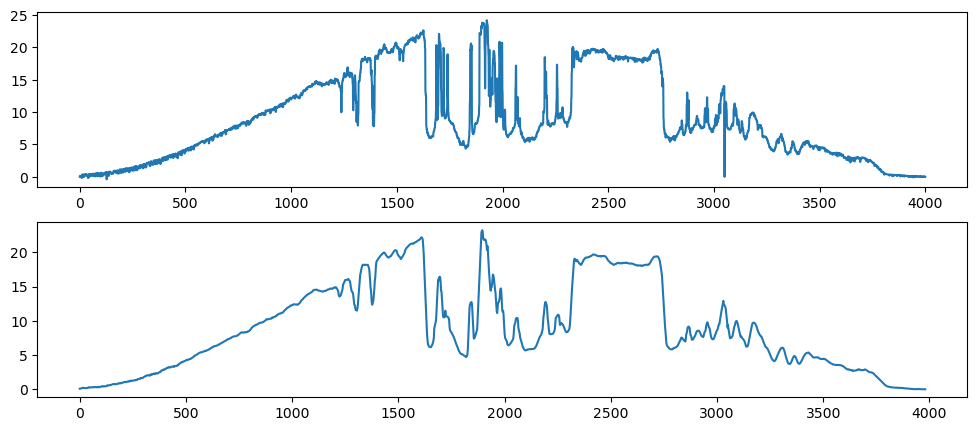

In [6]:
date = '2022-12-01'
ft = np.genfromtxt(f'./Data/{date}/{date}.csv', delimiter=', ', usecols=(0), dtype=str)
p = np.genfromtxt(f'./Data/{date}/{date}.csv', delimiter=', ', usecols=(1), dtype=float)
ma_p = moving_average(p,n=20)
print(ft.shape, p.shape, ma_p.shape)
fig,ax =  plt.subplots(2,1, figsize=(12,5))
ax[0].plot(p)
ax[1].plot(ma_p)
plt.show()

In [7]:
def plotData(date, raw_data, avg_data, randomFrame, nos_frames, cat_divisions, leap, avg_plot_title):
    ''' Plot the power level throughout the day while highlighting the randomly selected clip window
    Args:
        date: data collection date (string, for plot title)
        raw_data: numpy array of the plot data (first plot)
        avg_data: rolling averaged data (secong plot)
        randomFrame: randomply selected frame (int)
        nos_frames:  number of frames per clip
        cat_divisions: number of bins
        leap: future window of powerlevel extraction
        avg_plot_title: second plot title
    '''
    vectorized_powerCat = np.vectorize(PowerCategorize)
    power_cat = vectorized_powerCat(avg_data) # Convert the function into vectorizes so that it can be applied to numpy arrays

    fig,ax =  plt.subplots(3,1, figsize=(12,10),sharex=True)
    x1 = np.arange(0,len(raw_data),1)
    ax[0].fill_between(x1,raw_data, color="skyblue", alpha=0.4)
    ax[0].plot(x1, raw_data, color="Slateblue",alpha=0.8, linewidth=1)
    ax[0].set_title(f'Solar Power Generation: {date}',size=20)
    ax[1].plot(avg_data)
    ax[1].set_title(f'{avg_plot_title}',size=12)
    
    ax[1].axvspan(randomFrame, randomFrame+nos_frames, color="green", alpha=0.6)
    ax[1].axvspan(randomFrame+nos_frames,randomFrame+nos_frames+leap, color="red", alpha=0.4)
    ax[2].plot(power_cat)
    ax[2].set_title(f'Categorized Power levels: {cat_divisions}',size=12)
    ax[2].axvspan(randomFrame, randomFrame+nos_frames, color="green", alpha=0.6)
    ax[2].axvspan(randomFrame+nos_frames,randomFrame+nos_frames+leap, color="red", alpha=0.4)
    clear_output(wait = False)
    plt.show()

In [8]:
def dataContinutyTest(arr, sep='_', minDataCountPerHour=330,debug=False):
    ''' Test the data for any discontinuties due to power outages and system failures
    Args:
        arr: numpy time array
        sep: digit separater symbol
        minDataCountPerHour: number of minimum data point captured per hour
    Returns:
        Start and End frames of the longest continuous data stream
    '''
    out_arr = np.char.split(arr, sep=sep)
    count = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    start = 0
    end = 0
    total = 0
    for i in out_arr:
        h = int(i[0])
        count[h-6] += 1
    if debug: print(count)
    check = [1 if i > minDataCountPerHour else 0  for i in count]
    baseStr= ""
    for p in check:
        baseStr += str(p)
    if debug: print (baseStr)
    testStr = "111111111111"
    for i in reversed(range(len(count))):
        id = baseStr.find(testStr[:i])
        if id != -1: 
            start = id
            end = id+i
            break
    startFr = (sum(count[:start])+10) # Skipped 10 frames to settle down the exposure
    endFr = (sum(count[:end])-1)
    if debug: print(count[start:end])
    return startFr, endFr

In [9]:
frame_time = np.genfromtxt(f'./Data/2022-12-05/2022-12-05.csv', delimiter=', ', usecols=(0), dtype=str)
startFr, endFr = dataContinutyTest(frame_time,debug=True)
print(startFr,endFr)

[302, 337, 314, 338, 337, 338, 337, 337, 337, 337, 324, 336, 1]
0101111111010
[338, 337, 338, 337, 337, 337, 337]
954 3313


In [10]:
def generateClips(nos_clips, nos_frames, leap, cat_divisions, frame_rescale_ratio, imgPath, videoPath,fps=12, plotShow=False, original_frame_size=(2592,1944), rollingWindow=40):
    ''' Generate video clips form a image sets separated with dates 
    Args: 
        nos_clips:      Number of clips
        nos_frames:     Number of frames pe clip
        leap:           Shift from randomly selected frame to calculate the future average power
        cat_divisions:  Power categorize bin count   
        frame_rescale_ratio: Video rescale ratio (0.1=10%)
        imgPath:        Path to the image set separed by date
        videoPath:      Path to store generated video clips
        fps:            Frame rate of the clips generated
        plotShow:       Show plot with detaiils of the each generated clip (boolean) 
        original_frame_size: Tuple of the original image dimension (width,height)
    '''
    dateList = os.listdir(imgPath)
    print(f'Total number of dates: {len(dateList)}')
    counter = '0001'
    for numDate, date in enumerate(dateList):
        frame_time = np.genfromtxt(f'{imgPath}/{date}/{date}.csv', delimiter=', ', usecols=(0), dtype=str)
        power = np.genfromtxt(f'{imgPath}/{date}/{date}.csv', delimiter=', ', usecols=(1), dtype=float)
        ma_power = moving_average(power, n=rollingWindow) # length of the moving average will be less than the input lenght by the length of the window
        # print(frame_time.shape, power.shape, ma_power.shape)
        con_start, con_end = dataContinutyTest(frame_time,debug=False)
        totalContinuousData = con_end - con_start
        dataLoss = len(frame_time) - totalContinuousData
        dataLossPer = (dataLoss*100 / len(frame_time))

        if totalContinuousData > 1500:
            # for i in range(nos_clips):
            for i in progressbar(range(nos_clips), prefix=f'{numDate+1}. [{date}] [Data loss = {dataLoss}({dataLossPer:.1f}%)] - Generating: ', size=40):
                randomFrame = random.randint(con_start,(con_end-(leap+nos_frames+rollingWindow))) # limit the end range to moving average power shape
                frame_seq = []
                future_acc_power = 0
                current_acc_power = 0
                # print(f'totalFrame:{len(ma_power)} randomFrame:{randomFrame} futureFrame:{randomFrame+leap+nos_frames}')
                
                for i in range(nos_frames):
                    frame_seq.append(f'{imgPath}/{date}/' + frame_time[randomFrame+i] + '.jpg')
                    current_acc_power += ma_power[randomFrame+i] # Accumelate the future power value
                    future_acc_power += ma_power[randomFrame+leap+i] # Accumelate the future power value

                crnt_avg_power = current_acc_power/nos_frames
                future_average_power = future_acc_power/nos_frames

                crntCategory = PowerCategorize(crnt_avg_power, divisions=cat_divisions)
                futureCategory = PowerCategorize(future_average_power, divisions=cat_divisions)

                vid_label = str(crntCategory)
                store_dir = f'{videoPath}/{vid_label}'
                if not os.path.exists(store_dir): os.makedirs(store_dir)
                    
                if len(os.listdir(store_dir)) > 0: 
                    last_labelName = sorted(os.listdir(store_dir))[-1]
                    n = int(last_labelName[2:6])
                    counter = (str(n+1)).zfill(4)
                else: counter = '0001'

                avg_plot_title = f'{crntCategory}({crnt_avg_power:.1f})-{futureCategory}({future_average_power:.1f})'
                if plotShow :plotData(date=date, 
                                        raw_data=power, 
                                        avg_data=ma_power, 
                                        randomFrame=randomFrame, 
                                        nos_frames=nos_frames, 
                                        cat_divisions=cat_divisions, 
                                        leap=leap, 
                                        avg_plot_title=avg_plot_title)
                
                lowRes_frame = tuple([int(frame_rescale_ratio*x) for x in original_frame_size])
                out = cv.VideoWriter(f'{store_dir}/{vid_label}_{counter}.avi', cv.VideoWriter_fourcc(*'DIVX'), fps, lowRes_frame)

                for imgName in frame_seq:
                    img = rescale(cv.imread(imgName), frame_rescale_ratio)
                    out.write(img)
        else: print(f'[{date}] Skipped due to having too much data losses')
    print('-- Done --')

In [11]:
generateClips(nos_clips=500, 
                nos_frames=20, 
                leap=20,
                cat_divisions=5,
                frame_rescale_ratio=0.2,
                imgPath='./Data',
                videoPath='./Videos',
                fps=12,
                plotShow=False
                )

Total number of dates: 10
1. [2022-12-01] [Data loss = 970(24.2%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

2. [2022-12-02] [Data loss = 905(23.0%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

3. [2022-12-03] [Data loss = 198(5.1%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

4. [2022-12-04] [Data loss = 318(7.9%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

5. [2022-12-05] [Data loss = 1616(40.7%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

6. [2022-12-06] [Data loss = 961(24.1%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

7. [2022-12-07] [Data loss = 640(16.0%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

8. [2022-12-08] [Data loss = 1617(40.7%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500

9. [2022-12-09] [Data loss = 624(15.6%)] - Generating: [◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼◼] 500/500



KeyboardInterrupt: 

### Test-Train Split

In [1]:
!find ./Videos

./Videos
./Videos/0
./Videos/0/0_0360.avi
./Videos/0/0_0720.avi
./Videos/0/0_1080.avi
./Videos/0/0_0001.avi
./Videos/0/0_0002.avi
./Videos/0/0_0003.avi
./Videos/0/0_0004.avi
./Videos/0/0_0005.avi
./Videos/0/0_0006.avi
./Videos/0/0_0007.avi
./Videos/0/0_0008.avi
./Videos/0/0_0009.avi
./Videos/0/0_0010.avi
./Videos/0/0_0011.avi
./Videos/0/0_0012.avi
./Videos/0/0_0013.avi
./Videos/0/0_0014.avi
./Videos/0/0_0015.avi
./Videos/0/0_0016.avi
./Videos/0/0_0017.avi
./Videos/0/0_0018.avi
./Videos/0/0_0019.avi
./Videos/0/0_0021.avi
./Videos/0/0_0022.avi
./Videos/0/0_0023.avi
./Videos/0/0_0024.avi
./Videos/0/0_0025.avi
./Videos/0/0_0026.avi
./Videos/0/0_0027.avi
./Videos/0/0_0028.avi
./Videos/0/0_0029.avi
./Videos/0/0_0030.avi
./Videos/0/0_0031.avi
./Videos/0/0_0032.avi
./Videos/0/0_0033.avi
./Videos/0/0_0034.avi
./Videos/0/0_0035.avi
./Videos/0/0_0036.avi
./Videos/0/0_0037.avi
./Videos/0/0_0038.avi
./Videos/0/0_0039.avi
./Videos/0/0_0041.avi
./Videos/0/0_0042.avi
./Videos/0/0_0043.avi
./Videos/0/0

## Split the dataset

In [48]:
testRatio = 0.2
validateRatio = 0.2
trainRatio = 0.6
clipPath = '/media/anuradha/Volume_A/Anuradha/Projects/Solar_Prediction/Src/Videos/'
trainingPath = './Training/'
clipCount = []
clipNames = []
testNames = []
validateNames = []
trainNames = []
for i,name in enumerate(os.listdir(clipPath)):
    dir = clipPath + name
    clipNames.append(os.listdir(dir))
    clipCount.append(len(os.listdir(dir)))
minClipCount = min(clipCount)

c1 = int(minClipCount*testRatio)
c2 = int(minClipCount*testRatio + minClipCount*validateRatio)

for p,list in enumerate(clipNames): 
    random.shuffle(clipNames[p])
    testNames.append(clipNames[p][0:c1])
    validateNames.append(clipNames[p][c1:c2])
    trainNames.append(clipNames[p][c2:minClipCount])

dirName = './Testing/Test/'
if not os.path.exists(dirName): os.makedirs(dirName)
for i in range(5):
    for u in testNames[i]:
        vidPath = f'{clipPath}{i}/{u}'
        desPath = f'{dirName}{i}'
        if not os.path.exists(desPath): os.makedirs(desPath)
        shutil.copy(vidPath,desPath)

dirName = './Testing/Validate/'
if not os.path.exists(dirName): os.makedirs(dirName)
for i in range(5):
    for u in validateNames[i]:
        vidPath = f'{clipPath}{i}/{u}'
        desPath = f'{dirName}{i}'
        if not os.path.exists(desPath): os.makedirs(desPath)
        shutil.copy(vidPath,desPath)

dirName = './Testing/Train/'
if not os.path.exists(dirName): os.makedirs(dirName)
for i in range(5):
    for u in trainNames[i]:
        vidPath = f'{clipPath}{i}/{u}'
        desPath = f'{dirName}{i}'
        if not os.path.exists(desPath): os.makedirs(desPath)
        shutil.copy(vidPath,desPath)
    
        

352
70 140
1601
70
70
212


In [53]:
!find ./Testing/

./Testing/
./Testing/Test
./Testing/Test/0
./Testing/Test/0/0_0021.avi
./Testing/Test/0/0_0042.avi
./Testing/Test/0/0_0001.avi
./Testing/Test/0/0_0002.avi
./Testing/Test/0/0_0003.avi
./Testing/Test/0/0_0004.avi
./Testing/Test/0/0_0005.avi
./Testing/Test/0/0_0006.avi
./Testing/Test/0/0_0007.avi
./Testing/Test/0/0_0008.avi
./Testing/Test/0/0_0009.avi
./Testing/Test/0/0_0010.avi
./Testing/Test/0/0_0011.avi
./Testing/Test/0/0_0012.avi
./Testing/Test/0/0_0013.avi
./Testing/Test/0/0_0014.avi
./Testing/Test/0/0_0015.avi
./Testing/Test/0/0_0016.avi
./Testing/Test/0/0_0017.avi
./Testing/Test/0/0_0018.avi
./Testing/Test/0/0_0019.avi
./Testing/Test/0/0_0022.avi
./Testing/Test/0/0_0023.avi
./Testing/Test/0/0_0024.avi
./Testing/Test/0/0_0025.avi
./Testing/Test/0/0_0026.avi
./Testing/Test/0/0_0027.avi
./Testing/Test/0/0_0028.avi
./Testing/Test/0/0_0029.avi
./Testing/Test/0/0_0030.avi
./Testing/Test/0/0_0031.avi
./Testing/Test/0/0_0032.avi
./Testing/Test/0/0_0033.avi
./Testing/Test/0/0_0034.avi
./Tes

## Data feed pipeline

In [1]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [2]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv.VideoCapture(str(video_path))  

  video_length = src.get(cv.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append((frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [30]:
sample_video = frames_from_video_file('/media/anuradha/Volume_A/Anuradha/Projects/Solar_Prediction/Src/Testing/Test/4/4_0066.avi', n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

In [33]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


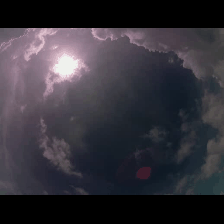

In [34]:
to_gif(sample_video)

In [4]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [15]:
train_path = pathlib.Path('/media/anuradha/Volume_A/Anuradha/Projects/Solar_Prediction/Src/Testing/Train')
test_path = pathlib.Path('/media/anuradha/Volume_A/Anuradha/Projects/Solar_Prediction/Src/Testing/Test')
val_path = pathlib.Path('/media/anuradha/Volume_A/Anuradha/Projects/Solar_Prediction/Src/Testing/Validate')

fg = FrameGenerator(train_path, 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 4


In [12]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32), tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_path, 10, training=True),output_signature = output_signature)

In [13]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(3, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(4, shape=(), dtype=int16)


In [16]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_path, 10),output_signature = output_signature)

In [17]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [19]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

2023-01-03 11:25:44.308499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 307 of 1000
2023-01-03 11:25:54.294884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 607 of 1000
2023-01-03 11:26:04.281726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 927 of 1000
2023-01-03 11:26:06.654514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-03 11:26:06.739359: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


2023-01-03 11:26:16.890248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 350 of 1000
2023-01-03 11:26:16.905382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


In [20]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds, 
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/10


2023-01-03 11:26:52.620143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 452 of 1000
2023-01-03 11:27:02.634366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 905 of 1000
2023-01-03 11:27:04.750235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


530/530 [==============================] - 222s 365ms/step - loss: 1.4665 - accuracy: 0.3755 - val_loss: 1.3489 - val_accuracy: 0.3371
Epoch 2/10
530/530 [==============================] - 189s 357ms/step - loss: 1.2069 - accuracy: 0.4962 - val_loss: 1.3687 - val_accuracy: 0.4743
Epoch 3/10
530/530 [==============================] - 203s 383ms/step - loss: 1.1096 - accuracy: 0.5292 - val_loss: 1.3039 - val_accuracy: 0.5229
Epoch 4/10
530/530 [==============================] - 205s 386ms/step - loss: 1.0330 - accuracy: 0.5821 - val_loss: 1.3440 - val_accuracy: 0.4686
Epoch 5/10
530/530 [==============================] - 201s 379ms/step - loss: 1.0048 - accuracy: 0.5868 - val_loss: 1.3918 - val_accuracy: 0.3229
